In [1]:
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from ComponentDataset import ComponentDataset
from BERTClassifier import BERTClassifier
from train_and_evaluate import train, evaluateModel

In [2]:
#iam
iam_stance_train_df = pd.read_csv('../stance_dataset/stance_train.txt', sep='\t', header=None, quoting=csv.QUOTE_NONE)
iam_stance_train_df.columns = ['claim_label', 'topic', 'claim', 'id', 'label']
iam_stance_test_df = pd.read_csv('../stance_dataset/stance_test.txt', sep='\t', header=None, quoting=csv.QUOTE_NONE)
iam_stance_test_df.columns = ['claim_label', 'topic', 'claim', 'id', 'label']
iam_stance_df = pd.concat([iam_stance_train_df, iam_stance_test_df])
iam_stance_df = iam_stance_df[['topic', 'claim', 'label']]
iam_stance_df = iam_stance_df[iam_stance_df['label'] != 0]
iam_stance_df['label'] = iam_stance_df['label'].replace(-1, 0)
iam_stance_df

,topic,claim,label
0,Should we ban the production of generic drugs,One long-standing solution to mitigating costs...,0
1,Should we ban the production of generic drugs,So there’s an almost universally accepted desi...,0
2,Should we ban the production of generic drugs,Even if this gets some people cheaper drugs in...,1
3,Should we ban the production of generic drugs,"For example, generics have been admonished for...",1
4,Should we ban the production of generic drugs,"Speaking of Shkreli, generics are just as capa...",1
...,...,...,...
522,Will artificial intelligence replace humans,Social manipulation: A superintelligence might...,1
523,Will artificial intelligence replace humans,An AGI need not be limited by human constraint...,1
524,Will artificial intelligence replace humans,The sheer complexity of human value systems ma...,0
525,Will artificial intelligence replace humans,"Physicist Stephen Hawking, Microsoft founder B...",1


In [3]:
#ibm
full_df = pd.read_csv('../stance_dataset/claim_stance_dataset_v1.csv')
selected_columns = ['topicText', 'claims.claimOriginalText', 'claims.stance']
ibm_df = full_df[selected_columns]
rename_columns = {'topicText': 'topic', 'claims.claimOriginalText': 'claim', 'claims.stance': 'label'}
ibm_df.rename(columns=rename_columns, inplace=True)
ibm_df['label'] = ibm_df['label'].map({'PRO': 1, 'CON': 0})
ibm_df

<ipython-input-3-7e952360ee83>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ibm_df.rename(columns=rename_columns, inplace=True)
<ipython-input-3-7e952360ee83>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ibm_df['label'] = ibm_df['label'].map({'PRO': 1, 'CON': 0})


,topic,claim,label
0,This house believes that the sale of violent v...,exposure to violent video games causes at leas...,1
1,This house believes that the sale of violent v...,video game violence is not related to serious ...,0
2,This house believes that the sale of violent v...,some violent video games may actually have a p...,0
3,This house believes that the sale of violent v...,exposure to violent video games causes both sh...,1
4,This house believes that the sale of violent v...,they increase the violent tendencies among youth,1
...,...,...,...
2389,This house would promote democratization,democracies have ever been found incompatible ...,0
2390,This house would promote democratization,democracy cannot subsist long nor be carried f...,0
2391,This house would promote democratization,democracy in general for ignoring the rights o...,0
2392,This house would promote democratization,democracy and freedom are indispensable ingred...,1


In [4]:
df = pd.concat([iam_stance_df, ibm_df])
df_support = df[df.label == 1]
df_attack = df[df.label == 0]
if df_support.shape[0] > df_attack.shape[0]:
    df_majority = df_support
    df_minority = df_attack
else:
    df_majority = df_attack
    df_minority = df_support

difference = df_majority.shape[0] - df_minority.shape[0]
random_minority_instance = df_minority.sample(n=difference, random_state=42)
df_minority = pd.concat([df_minority, random_minority_instance], ignore_index=True)
df_resampled = pd.concat([df_majority, df_minority])
df_resampled = df_resampled.sample(frac=1).reset_index(drop=True)
print(df_resampled.shape[0])

claims = df_resampled['claim'].tolist()
topics = df_resampled['topic'].tolist()
labels = df_resampled['label'].tolist()

7358


In [40]:
bert_model_name = 'bert-large-cased'
num_classes = 2
max_length = 256
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

In [41]:
train_claims, val_claims, train_topics, val_topics,train_stances, val_stances = train_test_split(claims, topics, labels, test_size=0.2, random_state=42)

In [42]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = ComponentDataset(train_claims, train_topics, train_stances, tokenizer, max_length)
val_dataset = ComponentDataset(val_claims, val_topics, val_stances, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [44]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [47]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluateModel(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/4
Validation Accuracy: 0.7724
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       766
           1       0.74      0.82      0.77       706

    accuracy                           0.77      1472
   macro avg       0.77      0.77      0.77      1472
weighted avg       0.78      0.77      0.77      1472

Epoch 2/4
Validation Accuracy: 0.8390
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       766
           1       0.83      0.84      0.83       706

    accuracy                           0.84      1472
   macro avg       0.84      0.84      0.84      1472
weighted avg       0.84      0.84      0.84      1472

Epoch 3/4
Validation Accuracy: 0.8573
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       766
           1       0.87      0.82      0.85       706

    accuracy                           0.86      1472
   macro avg  

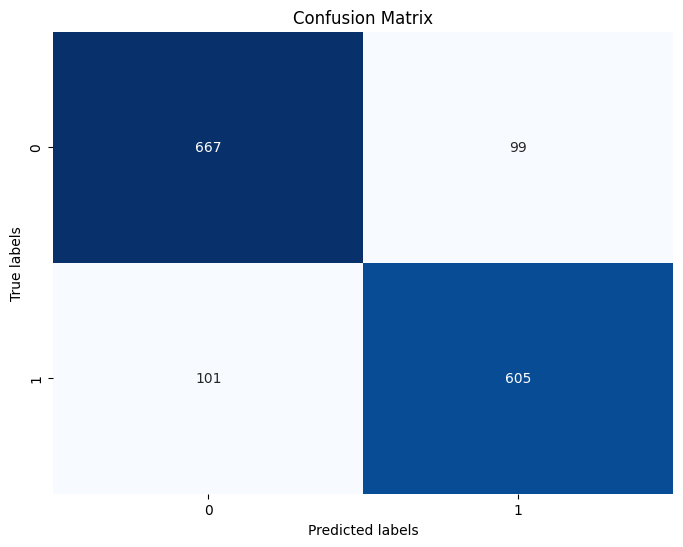

In [48]:
def draw_confusion_matrix(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    cm = confusion_matrix(actual_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    # plt.savefig("claim.png")

draw_confusion_matrix(model, val_dataloader, device)

In [49]:
model_path = '../models/stance.pth'
torch.save(model.state_dict(), model_path)